# HW 2: Program Graph $\rightarrow$ Transition System

In this exercise, we will implement the formal concept of a Program Graph (PG) as we defined in class using Python classes. We will also implement the `to_transition_system()` method to convert a program graph into a transition system.


In [1]:
import sys
import otter
# try:
#   import otter
# except ImportError:
#     %pip install otter-grader
#     import otter

grader = otter.Notebook("HW2.ipynb")

## Challenge 1: Implementing the `ProgramGraph` class

### **Formal Definition**
A **Program Graph** (PG) is a tuple: $(Loc, Act, Effect, \rightarrow, Loc_0, g_0)$
where:
- $Loc$ is a finite set of program locations (control points).
- $Act$ is a set of actions (instructions that modify variables).
- $Effect$ is a function that applies an action to an environment and produces a new environment.
- $Transitions \subseteq Loc \times Cond \times Act \times Loc$ is a set of edges where:
    - $Cond$ is a condition that must hold for the transition.
    - $Act$ is the action that modifies the variables.
    - The edge represents moving from an **old location** to a **new location** under **condition** $Cond$ and **action** $Act$.
- $Loc_0 \subseteq Loc$ is a finite set of initial locations.
- $g_0$ is an initial condition on the program variables.
- $Eval$ is a function that evaluates conditions on variables.


### Example

Let’s define a **simple program graph** for a counter that increments from 0 to 2.

- $Loc = \{L_0, L_1, L_2\}$
- $Loc_0 = \{L_0\}$
- $Act = \{x += 1\}$
- $\rightarrow = \{(L_0, x < 2, x += 1, L_1), (L_1, x < 2, x += 1, L_2)\}$
- $g_0 = \{x = 0\}$

### Use `HashableDict`


In this exercise we will represent environments (variable assignments) as part of the states in a **Transition System**, which requires them to be **hashable** (so they can be used in sets and dictionaries). However, **Python dictionaries are mutable and not hashable by default**.

By defining `HashableDict`, which inherits from `dict` and implements `__hash__` using `frozenset(self.items())`, we create an **immutable, hashable representation** of environments while preserving dictionary-like behavior for easy lookups and modifications.


In [2]:
class HashableDict(dict):
    def __hash__(self):
        return hash(frozenset(self.items()))

Your task is to implement the `ProgramGraph` class in Python. The class should have the following methods:

In [3]:
from typing import Callable, Set, Tuple, Dict, List, Union , Optional
import matplotlib.pyplot as plt
import networkx as nx

# Add your imports here, don't forget to include your TransitionSystem class
from collections import deque
import itertools


#------------------------start of transition system class#-----------------------
State = Union[str, Tuple]  # A state can be a string or a tuple (location, environment)
Action = str  # Actions are represented as strings
Transition = Tuple[State, Action, State]  # (source_state, action, target_state)
LabelingMap = Dict[State, Set[str]]  # Maps states to atomic propositions


class TransitionSystem:
    """
    A Transition System (TS) representation.

    Attributes:
        S (Set[State]): The set of all states (strings or tuples).
        Act (Set[Action]): The set of all possible actions.
        Transitions (Set[Transition]): The set of transitions, each represented as (state_origin, action, state_target).
        I (Set[State]): The set of initial states.
        AP (Set[str]): The set of atomic propositions.
        _L (LabelingMap): A dictionary mapping states to their respective atomic propositions.
    """

    def __init__(
        self,
        states: Optional[Set[State]] = None,
        actions: Optional[Set[Action]] = None,
        transitions: Optional[Set[Transition]] = None,
        initial_states: Optional[Set[State]] = None,
        atomic_props: Optional[Set[str]] = None,
        labeling_map: Optional[LabelingMap] = None,
    ) -> None:
        """
        Initializes the Transition System.

        :param states: A set of states (each a string or a tuple). Defaults to an empty set.
        :param actions: A set of actions. Defaults to an empty set.
        :param transitions: A set of transitions, each as (state_origin, action, state_target). Defaults to an empty set.
        :param initial_states: A set of initial states. Defaults to an empty set.
        :param atomic_props: A set of atomic propositions. Defaults to an empty set.
        :param labeling_map: A dictionary mapping states to sets of atomic propositions. Defaults to an empty dictionary.
        """
        self.S: Set[State] = set(states) if states is not None else set()
        self.Act: Set[Action] = set(actions) if actions is not None else set()
        self.Transitions: Set[Transition] = set(transitions) if transitions is not None else set()
        self.I: Set[State] = set(initial_states) if initial_states is not None else set()
        self.AP: Set[str] = set(atomic_props) if atomic_props is not None else set()
        self._L: LabelingMap = dict(labeling_map) if labeling_map is not None else {}

    def add_state(self, *states: State) -> "TransitionSystem":
        """
        Adds one or more states to the transition system.

        :param states: One or more states (strings or tuples) to be added.
        :return: The TransitionSystem instance (for method chaining).
        """

        # Check if all states are either strings or tuples
        # I'm not sure if the check is needed here, but let's keep it for safety
        if not all(isinstance(state, (str, tuple)) for state in states):
            raise ValueError("States must be strings or tuples.")
        
        self.S.update(states)
        return self

    def add_action(self, *actions: Action) -> "TransitionSystem":
        """
        Adds one or more actions to the transition system.

        :param actions: One or more actions (strings) to be added.
        :return: The TransitionSystem instance (for method chaining).
        """
        # Check if all actions are strings
        # I'm not sure if the check is needed here, but let's keep it for safety
        if not all(isinstance(action, str) for action in actions):
            raise ValueError("Actions must be strings.")

        self.Act.update(actions)
        return self

    def add_transition(self, *transitions: Transition) -> "TransitionSystem":
        """
        Adds one or more transitions to the transition system.
        Ensures that all involved states and actions exist before adding the transitions.

        Each transition must be provided as a tuple of the form `(state_from, action, state_to)`, where:
        - `state_from` is the source state.
        - `action` is the action performed.
        - `state_to` is the resulting state.

        :param transitions: One or more transitions, each as a tuple `(state_from, action, state_to)`.
        :raises ValueError:
            - If a transition is not a tuple of length 3.
            - If `state_from` or `state_to` does not exist in `self.S`.
            - If `action` is not in `self.Act`.
        :return: The `TransitionSystem` instance (for method chaining).
        """
        
        # Check if all states and actions in the transitions exist in the system
        for transition in transitions:
            if not isinstance(transition, tuple) or len(transition) != 3:
                raise ValueError(f"Invalid transition format: {transition}. Must be a tuple of (state_from, action, state_to).")
            
            # Unpack the transition tuple
            state_from, action, state_to = transition

            # Check if state_from, action, and state_to are valid
            if state_from not in self.S:
                raise ValueError(f"State {state_from} is not in the transition system.")
            if state_to not in self.S:
                raise ValueError(f"State {state_to} is not in the transition system.")
            if action not in self.Act:
                raise ValueError(f"Action {action} is not in the transition system.")

            self.Transitions.add(transition)

        return self

    def add_initial_state(self, *states: State) -> "TransitionSystem":
        """
        Adds one or more states to the set of initial states.

        :param states: One or more states to be marked as initial.
        :raises ValueError: If any state does not exist in the system.
        :return: The TransitionSystem instance (for method chaining).
        """
        # Check if all states are in the system
        for state in states:
            if state not in self.S:
                raise ValueError(f"Initial state {state} must be in the transition system.")
        
        self.I.update(states)
        return self

    def add_atomic_proposition(self, *props: str) -> "TransitionSystem":
        """
        Adds one or more atomic propositions to the transition system.

        :param props: One or more atomic propositions (strings) to be added.
        :return: The TransitionSystem instance (for method chaining).
        """
        # Check if all props are strings
        # I'm not sure if the check is needed here, but let's keep it for safety
        if not all(isinstance(prop, str) for prop in props):
            raise ValueError("Atomic propositions must be strings.")
        
        self.AP.update(props)
        return self

    def add_label(self, state: State, *labels: str) -> "TransitionSystem":
        """
        Adds one or more atomic propositions to a given state.

        :param state: The state to label.
        :param labels: One or more atomic propositions to be assigned to the state.
        :raises ValueError: If the state is not in the system or if any label is not a valid atomic proposition.
        :return: The TransitionSystem instance (for method chaining).
        """
        # Check if the state exists in the system
        if state not in self.S:
            raise ValueError(f"Cannot set labels for {state}. State is not in the transition system.")
        
        # Check if all labels are valid atomic propositions
        invalid_labels = {label for label in labels if label not in self.AP}
        if invalid_labels:
            raise ValueError(f"Cannot assign labels {invalid_labels}. They are not in the set of atomic propositions (AP).")

        # Add labels to the state
        if state not in self._L:
            self._L[state] = set()
        self._L[state].update(labels)
        
        return self

    def L(self, state: State) -> Set[str]:
        """
        Retrieves the set of atomic propositions that hold in a given state.

        :param state: The state whose atomic propositions are being retrieved.
        :raises ValueError: If the state is not in the transition system.
        :return: A set of atomic propositions associated with the given state.
        """
        # Check if the state exists in the system
        if state not in self.S:
            raise ValueError(f"State {state} is not in the transition system.")
        
        # Return the labels for the state, or an empty set if none exist
        return self._L.get(state, set())

    def pre(self, S: Union[State, Set[State]], action: Optional[Action] = None) -> Set[State]:
        """
        Computes the set of predecessor states from which a given state or set of states can be reached.

        :param S: A single state (string/tuple) or a collection of states.
        :param action: (Optional) If provided, filters only the transitions that use this action.
        :return: A set of predecessor states.
        """

        # Check if S is a single state or a set of states
        if not isinstance(S, set):
            S = {S}

        predecessors = set()

        for state_from, act, state_to in self.Transitions:
            # Check if the transition leads to a state in S and if the action matches (if provided)
            # If action is None, it means we want all transitions leading to S
            # If action is provided, we only want transitions with that action
            # Check if the transition leads to a state in S and if the action matches (if provided)
            # If action is None, it means we want all transitions leading to S
            if state_to in S and (action is None or act == action):
                predecessors.add(state_from)
    
        return predecessors


    def post(self, S: Union[State, Set[State]], action: Optional[Action] = None) -> Set[State]:
        """
        Computes the set of successor states reachable from a given state or a collection of states.

        :param S: A single state or a collection of states.
        :param action: (Optional) Filters transitions by this action.
        :return: A set of successor states.
        """
        # Check if S is a single state or a set of states
        if not isinstance(S, set):
            S = {S}

        successors = set()

        for state_from, act, state_to in self.Transitions:
            if state_from in S and (action is None or act == action):
                successors.add(state_to)

        return successors

    def reach(self) -> Set[State]:
        """
        Computes the set of all reachable states from the initial states.

        :return: A set of reachable states.
        """

        # If there are no initial states, return an empty set
        if not self.I:
            return set()
    
        reachable = set(self.I)
        frontier = set(self.I)
        
        # Perform a breadth-first search (BFS) to find all reachable states
        while frontier:
            new_frontier = set()
            for state in frontier:
                successors = self.post(state)
                new_states = successors - reachable
                reachable.update(new_states)
                new_frontier.update(new_states)
            frontier = new_frontier
        
        return reachable

    def is_action_deterministic(self) -> bool:
        """
        Checks whether the transition system is action-deterministic.

        A transition system is action-deterministic if:
        - It has at most one initial state.
        - For each state and action, there is at most one successor state.

        :return: True if the transition system is action-deterministic, False otherwise.
        """
        # Check if there is at most one initial state
        if len(self.I) > 1:
            return False
    
    # For each state and action, check if there is at most one successor
        for state in self.S:
            for action in self.Act:
                if len(self.post(state, action)) > 1:
                    return False
                
        return True
        

    def is_label_deterministic(self) -> bool:
        """
        Checks whether the transition system is label-deterministic.

        A transition system is label-deterministic if:
        - It has at most one initial state.
        - For each state, the number of reachable successor states is equal to the number of unique label sets
          of these successor states.

        :return: True if the transition system is label-deterministic, False otherwise.
        """
    # Check if there is at most one initial state
        if len(self.I) > 1:
            return False
        
        # For each state, check if all successor states have distinct labels
        for state in self.S:
            successors = self.post(state)
            if not successors:
                continue
            
            # Get the labels of all successor states
            successor_labels = [frozenset(self.L(s)) for s in successors]
            
            # Check if the number of distinct labels is equal to the number of successors
            if len(set(successor_labels)) != len(successors):
                return False
        
        return True

    def __repr__(self) -> str:
        """
        Returns a string representation of the Transition System.

        :return: A formatted string representation of the TS.
        """
        return (
            f"TransitionSystem(\n"
            f"  States: {self.S}\n"
            f"  Actions: {self.Act}\n"
            f"  Transitions: {len(self.Transitions)}\n"
            f"  Initial States: {self.I}\n"
            f"  Atomic Propositions: {self.AP}\n"
            f"  Labels: {self._L}\n"
            f")"
        )


    def plot(self, title: str = "Transition System", figsize: Tuple[int, int] = (10, 6)) -> None:
        """
        Plots the Transition System as a directed graph.

        :param title: Title of the plot.
        :param figsize: Figure size for the plot.
        """
        G = nx.DiGraph()

        # Add nodes (states)
        for state in self.S:
            label = f"{state}\n{' '.join(self.L(state))}" if self.L(state) else str(state)
            print(label)
            G.add_node(state, label=label, color="blue" if state in self.I else "yellow")

        # Add edges (transitions)
        for state_from, action, state_to in self.Transitions:
            G.add_edge(state_from, state_to, label=action)

        plt.figure(figsize=figsize)
        pos = nx.spring_layout(G)  # Positioning algorithm for layout

        # Draw nodes
        node_colors = [G.nodes[n]["color"] for n in G.nodes]
        nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, "label"), node_color=node_colors, edgecolors="black", node_size=2000, font_size=10)

        # Draw edge labels (actions)
        edge_labels = {(u, v): d["label"] for u, v, d in G.edges(data=True)}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

        plt.title(title)
        plt.show()



#------------------------end of transition system class#------------------------


Location = Union[str, Tuple]  # A state can be a string or a tuple (location, environment)
Condition = str # Conditions are represented as strings
#Action = str  # Already Defined above
Transition = Tuple[Location, Condition, Action, Location]  # (source_state, action, target_state)
Environment = Dict[str, Union[str, bool, int, float]]      # Variable assignments


class ProgramGraph:
    def __init__(
        self,
        locations: Set[Location],
        initial_locations: Set[Location],
        actions: Set[Action],
        transitions: Set[Transition],
        eval_fn: Callable[[Condition, Environment], bool],
        effect_fn: Callable[[Action, Environment], Environment],
        g0: Condition
    ):
        """
        A representation of a Program Graph.

        :param locations: Set of all program locations (Loc).
        :param initial_locations: Set of initial locations (Loc0).
        :param actions: Set of possible actions (Act).
        :param transitions: Set of transitions in the form (loc_from, condition, action, loc_to).
        :param eval_fn: Function to evaluate a condition string in an environment.
        :param effect_fn: Function to compute the new environment after applying an action.
        :param g0: Initial condition string for filtering valid starting environments.
        """
        self.Loc = set(locations)
        self.Loc0 = set(initial_locations)
        self.Act = set(actions)
        self.Transitions = set(transitions)
        self.eval_fn = eval_fn
        self.effect_fn = effect_fn
        self.g0 = g0

    def add_location(self, *locations: Location) -> "ProgramGraph":
        """Add one or more locations to the program graph."""
        self.Loc.update(locations)
        return self

    def add_action(self, *actions: Action) -> "ProgramGraph":
        """Add one or more actions to the program graph."""
        self.Act.update(actions)
        return self

    def add_transition(self, *transitions: Transition) -> "ProgramGraph":
        """
        Add one or more transitions to the program graph.

        Each transition must be a tuple: (loc_from, condition, action, loc_to).
        """
        for transition in transitions:
            if not isinstance(transition, tuple) or len(transition) != 4:
                raise ValueError(f"Invalid transition format: {transition}. Expected (loc_from, cond, action, loc_to).")
            loc_from, cond, action, loc_to = transition
            if loc_from not in self.Loc:
                raise ValueError(f"Location {loc_from} is not in the program graph.")
            if loc_to not in self.Loc:
                raise ValueError(f"Location {loc_to} is not in the program graph.")
            if action not in self.Act:
                raise ValueError(f"Action {action} is not in the program graph.")

            self.Transitions.add(transition)
        return self

    def add_initial_location(self, *locations: Location) -> "ProgramGraph":
        """Add one or more initial locations to the program graph."""
        for loc in locations:
            if loc not in self.Loc:
                raise ValueError(f"Cannot set initial location {loc}. Location is not in the set of locations.")
            self.Loc0.add(loc)
        return self

    def set_eval_fn(self, eval_fn: Callable[[Condition, Environment], bool]) -> "ProgramGraph":
        """Set the function used to evaluate conditions."""
        self.eval_fn = eval_fn
        return self

    def set_effect_fn(self, effect_fn: Callable[[Action, Environment], Environment]) -> "ProgramGraph":
        """Set the function used to apply actions to environments."""
        self.effect_fn = effect_fn
        return self

    def eval(self, condition: Condition, env: Environment) -> bool:
        """Evaluate a condition string in the given environment."""
        return self.eval_fn(condition, env)

    def effect(self, action: Action, env: Environment) -> Environment:
        """Apply an action to the environment and return the new environment."""
        return self.effect_fn(action, env)
        

    def valid_transitions(self, loc: Location, env: Environment, action: Action) -> List[Tuple[Location, Action, Location]]:
        """
        Return a list of valid transitions from a given location using the provided environment and action.
        """
        valid = []
        for loc_from, cond, act, loc_to in self.Transitions:
            if loc_from == loc and act == action:
                # Ensure env is passed correctly to eval_fn
                current_env_dict = dict(env) # eval_fn might expect a standard dict
                if self.eval(cond, current_env_dict):
                    valid.append((loc_from, act, loc_to))
        return valid

    def to_transition_system(self, vars: Dict[str, Set[Union[str, bool, int, float]]], labels: Set[Condition]) -> TransitionSystem:
        """
        Construct and return a Transition System from the program graph.

        :param vars: A dictionary mapping variable names to their finite sets of possible values.
        :param labels: A set of atomic proposition strings to be used for labeling states.
        :return: A TransitionSystem instance corresponding to the program graph.
        """
        ts = TransitionSystem()
        ts.add_action(*self.Act)
        # Add program locations and provided labels as atomic propositions
        ts.add_atomic_proposition(*self.Loc)
        ts.add_atomic_proposition(*labels)

        # Generate all possible initial environments satisfying g0
        var_names = list(vars.keys())
        value_combinations = itertools.product(*(vars[vn] for vn in var_names))
        initial_environments = []
        for values in value_combinations:
            env = HashableDict(zip(var_names, values))
            if self.eval(self.g0, dict(env)): # eval_fn expects dict
                 initial_environments.append(env)

        # Generate initial TS states
        initial_ts_states = set()
        for loc0 in self.Loc0:
             if loc0 not in self.Loc: continue # Skip if initial loc not in Loc
             for env0 in initial_environments:
                 ts_state = (loc0, env0)
                 initial_ts_states.add(ts_state)
                 # Add state and label it immediately
                 ts.add_state(ts_state)
                 ts.add_label(ts_state, loc0) # Label with PG location
                 for prop in labels:
                     if self.eval(prop, dict(env0)): # eval_fn expects dict
                         ts.add_label(ts_state, prop)


        ts.add_initial_state(*initial_ts_states)

        # Reachability analysis
        reachable_states = set(initial_ts_states)
        worklist = deque(initial_ts_states)
        processed_transitions = set() # To avoid redundant checks

        while worklist:
            current_ts_state = worklist.popleft()
            loc, current_env = current_ts_state
            current_env_dict = dict(current_env) # Use dict for eval/effect

            # Explore PG transitions from the current location 'loc'
            for pg_trans in self.Transitions:
                loc_from, cond, action, loc_to = pg_trans

                if loc_from == loc:
                    # Check if this specific transition from this state has been processed
                    trans_key = (current_ts_state, action, loc_to)
                    if trans_key in processed_transitions:
                        continue

                    if self.eval(cond, current_env_dict):
                        # Apply effect
                        next_env_dict = self.effect(action, current_env_dict)

                        # Validate next_env against 'vars'
                        is_valid_env = True
                        for var_name, value in next_env_dict.items():
                            if var_name in vars and value not in vars[var_name]:
                                is_valid_env = False
                                break # Value out of defined range

                        if is_valid_env:
                            next_env_hashable = HashableDict(next_env_dict)
                            next_ts_state = (loc_to, next_env_hashable)

                            # Add state and label if new
                            if next_ts_state not in ts.S:
                                ts.add_state(next_ts_state)
                                ts.add_label(next_ts_state, loc_to) # Label with PG location
                                for prop in labels:
                                     if self.eval(prop, next_env_dict):
                                         ts.add_label(next_ts_state, prop)

                            # Add the TS transition
                            ts.add_transition((current_ts_state, action, next_ts_state))
                            processed_transitions.add(trans_key) # Mark as processed

                            # If the next state is newly reached, add to worklist
                            if next_ts_state not in reachable_states:
                                reachable_states.add(next_ts_state)
                                worklist.append(next_ts_state)

        # Ensure all reachable states are in the TS (should be covered by add_state/add_transition)
        # ts.S = reachable_states # Optionally restrict S to only reachable states

        return ts

    def __repr__(self):
                return (
            f"ProgramGraph(\n"
            f"  Loc: {self.Loc}\n"
            f"  Act: {self.Act}\n"
            f"  Transitions: {self.Transitions}\n"
            f"  Loc0: {self.Loc0}\n"
            f"  g0: {self.g0}\n"
            f")"
        )

    def plot(self):
        """
        Visualize the program graph as a directed graph using networkx and matplotlib.

        Nodes are locations. Edges are labeled with (condition, action).
        """
        G = nx.MultiDiGraph()

        # Add nodes
        for loc in self.Loc:
            G.add_node(loc, color='lightblue' if loc in self.Loc0 else 'white')

        # Add edges with (condition, action) labels
        for (loc_from, cond, action, loc_to) in self.Transitions:
            label = f"{cond} / {action}"
            G.add_edge(loc_from, loc_to, label=label)

        pos = nx.spring_layout(G, seed=42)  # consistent layout

        # Draw nodes with color
        node_colors = [G.nodes[n].get('color', 'white') for n in G.nodes]
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, edgecolors='black')
        nx.draw_networkx_labels(G, pos)

        # Draw edges
        nx.draw_networkx_edges(G, pos, arrows=True)

        # Draw edge labels
        edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

        # Display
        plt.title("Program Graph")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

## Example: Program Graph to Transition System Conversion

In the cell bellow, we define helper functions `eval_fn` and `effect_fn` using the Python interpreter. These functions are used to evaluate conditions and apply actions within a given environment. We then create a simple program graph for a counter that increments from 0 to 2 and convert it to a transition system.

States: {('L0', {'x': 0}), ('L1', {'x': 1}), ('L2', {'x': 2})}

Transitions:
(('L0', {'x': 0}), 'x += 1', ('L1', {'x': 1}))
(('L1', {'x': 1}), 'x += 1', ('L2', {'x': 2}))


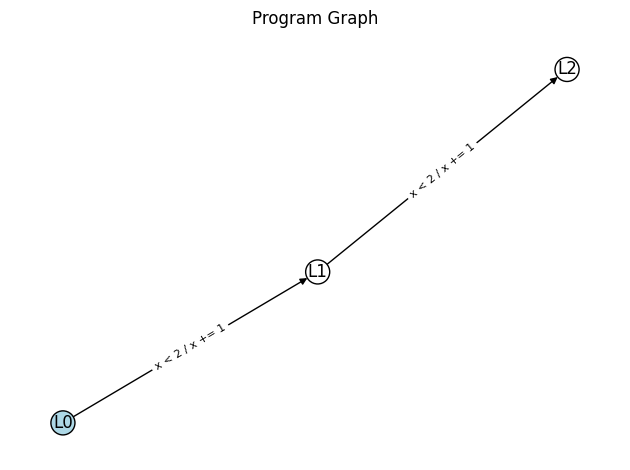

('L0', {'x': 0})
L0 x < 2
('L1', {'x': 1})
L1 x < 2
('L2', {'x': 2})
x == 2 L2


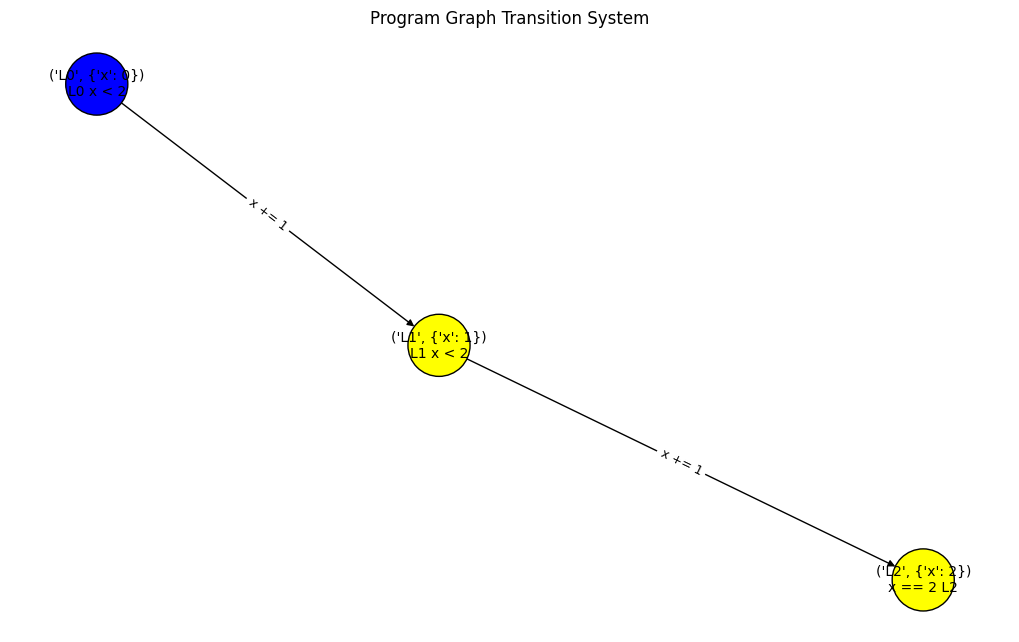

In [4]:
# Define helper functions for evaluation and effects
def eval_fn(cond, env):
    """Evaluates a condition string in a given environment dictionary."""
    try:
        return eval(cond, {}, env)
    except:
        return False

def effect_fn(action, env):
    """Applies an action (which modifies variables) and returns a new environment."""
    new_env = env.copy()
    try:
        exec(action, {}, new_env)
    except:
        pass
    return new_env

# Create a simple program graph for a counter that increments from 0 to 2
pg = ProgramGraph(
    locations={'L0', 'L1', 'L2'},
    initial_locations={'L0'},
    actions={'x += 1'},
    transitions={
        ('L0', 'x < 2', 'x += 1', 'L1'),
        ('L1', 'x < 2', 'x += 1', 'L2')
    },
    eval_fn=eval_fn,
    effect_fn=effect_fn,
    g0='x == 0'  # Initial condition: x starts at 0
)

# Convert to transition system
vars = {'x': {0, 1, 2}}  # Possible values for x
labels = {'x < 2', 'x == 2'}  # Properties we want to track
ts = pg.to_transition_system(vars, labels)

# Print the states and transitions
print("States:", ts.S)
print("\nTransitions:")
for transition in ts.Transitions:
    print(transition)


pg.plot()
ts.plot(title="Program Graph Transition System")

## Example: My Tests

States: {('L0', {'x': 0}), ('L1', {'x': 1}), ('L3', {'x': 3}), ('L2', {'x': 2})}

Transitions:
(('L3', {'x': 3}), 'x = 0', ('L0', {'x': 0}))
(('L2', {'x': 2}), 'x += 1', ('L3', {'x': 3}))
(('L0', {'x': 0}), 'x += 1', ('L1', {'x': 1}))
(('L1', {'x': 1}), 'x += 1', ('L2', {'x': 2}))

Valid transitions from L0 with x=0: [('L0', 'x += 1', 'L1')]
Valid transitions from L3 with x=3: [('L3', 'x = 0', 'L0')]


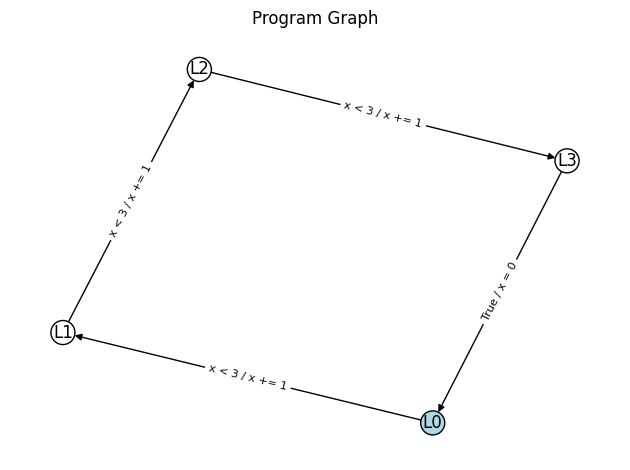

('L0', {'x': 0})
L0 x == 0 x < 3
('L1', {'x': 1})
L1 x < 3
('L3', {'x': 3})
x == 3 L3
('L2', {'x': 2})
L2 x < 3


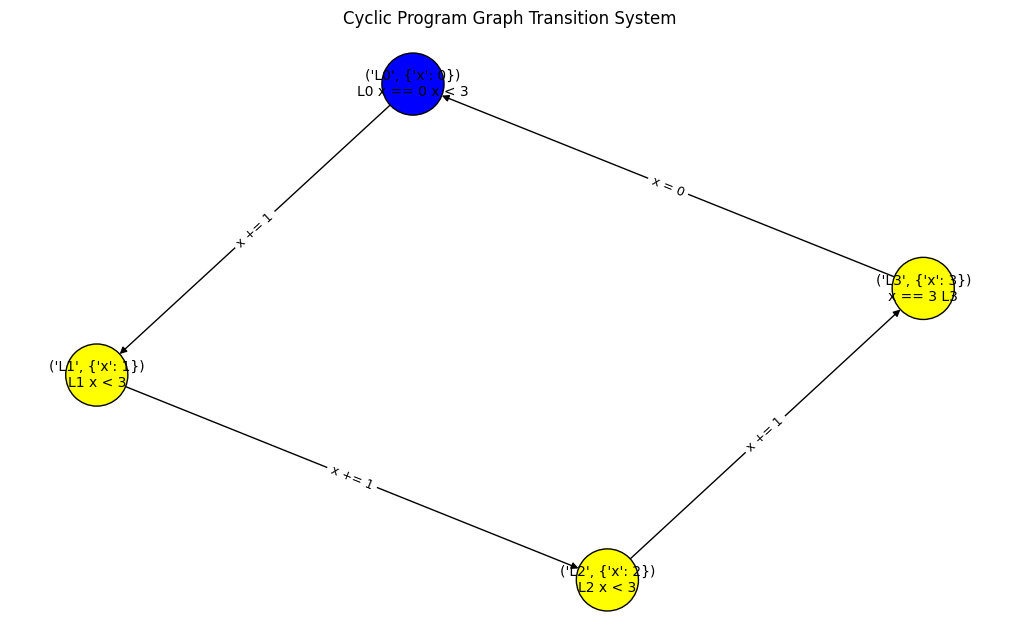

In [5]:
# Program graph with a loop that counts from 0 to 3, then resets to 0
loop_pg = ProgramGraph(
    locations={'L0', 'L1', 'L2', 'L3'},
    initial_locations={'L0'},
    actions={'x += 1', 'x = 0'},
    transitions={
        ('L0', 'x < 3', 'x += 1', 'L1'),
        ('L1', 'x < 3', 'x += 1', 'L2'),
        ('L2', 'x < 3', 'x += 1', 'L3'),
        ('L3', 'True', 'x = 0', 'L0')  # Reset back to L0
    },
    eval_fn=eval_fn,
    effect_fn=effect_fn,
    g0='x == 0'
)

# Convert to transition system and test
loop_vars = {'x': {0, 1, 2, 3}}
loop_labels = {'x < 3', 'x == 3', 'x == 0'}
loop_ts = loop_pg.to_transition_system(loop_vars, loop_labels)

# Print the states and transitions
print("States:", loop_ts.S)
print("\nTransitions:")
for transition in loop_ts.Transitions:
    print(transition)

# Test valid_transitions
env = {'x': 0}
valid_from_L0 = loop_pg.valid_transitions('L0', env, 'x += 1')
print("\nValid transitions from L0 with x=0:", valid_from_L0)

env = {'x': 3}
valid_from_L3 = loop_pg.valid_transitions('L3', env, 'x = 0')
print("Valid transitions from L3 with x=3:", valid_from_L3)

# Visualize
loop_pg.plot()
loop_ts.plot(title="Cyclic Program Graph Transition System")

States: {('End', {'x': 1, 'y': 1, 'z': 0}), ('Middle', {'x': 2, 'y': 1, 'z': 2}), ('Start', {'x': 0, 'y': 0, 'z': 0}), ('End', {'x': 2, 'y': 3, 'z': 2}), ('Start', {'x': 2, 'y': 3, 'z': 5}), ('Middle', {'x': 1, 'y': 0, 'z': 0}), ('Start', {'x': 1, 'y': 1, 'z': 2})}

Transitions:
(('End', {'x': 2, 'y': 3, 'z': 2}), 'z = x + y', ('Start', {'x': 2, 'y': 3, 'z': 5}))
(('Middle', {'x': 2, 'y': 1, 'z': 2}), 'y += x', ('End', {'x': 2, 'y': 3, 'z': 2}))
(('Start', {'x': 1, 'y': 1, 'z': 2}), 'x += 1', ('Middle', {'x': 2, 'y': 1, 'z': 2}))
(('Start', {'x': 0, 'y': 0, 'z': 0}), 'x += 1', ('Middle', {'x': 1, 'y': 0, 'z': 0}))
(('Middle', {'x': 1, 'y': 0, 'z': 0}), 'y += x', ('End', {'x': 1, 'y': 1, 'z': 0}))
(('End', {'x': 1, 'y': 1, 'z': 0}), 'z = x + y', ('Start', {'x': 1, 'y': 1, 'z': 2}))

Valid transitions from Middle with x=1, y=2: [('Middle', 'y += x', 'End')]


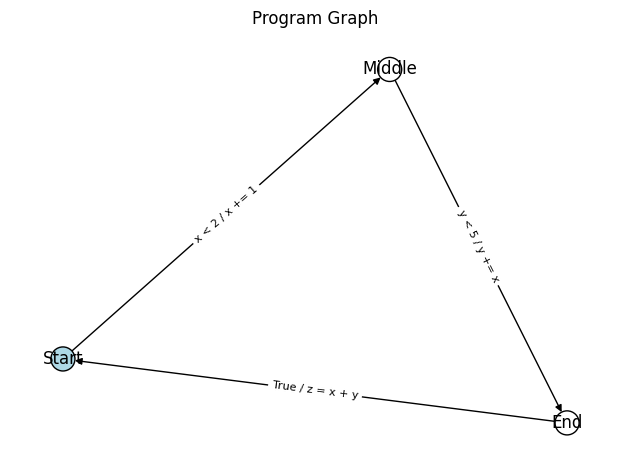

('End', {'x': 1, 'y': 1, 'z': 0})
y < 5 End x < 2
('Middle', {'x': 2, 'y': 1, 'z': 2})
Middle y < 5
('Start', {'x': 0, 'y': 0, 'z': 0})
Start y < 5 x < 2
('End', {'x': 2, 'y': 3, 'z': 2})
y < 5 End
('Start', {'x': 2, 'y': 3, 'z': 5})
Start y < 5
('Middle', {'x': 1, 'y': 0, 'z': 0})
Middle y < 5 x < 2
('Start', {'x': 1, 'y': 1, 'z': 2})
Start y < 5 x < 2


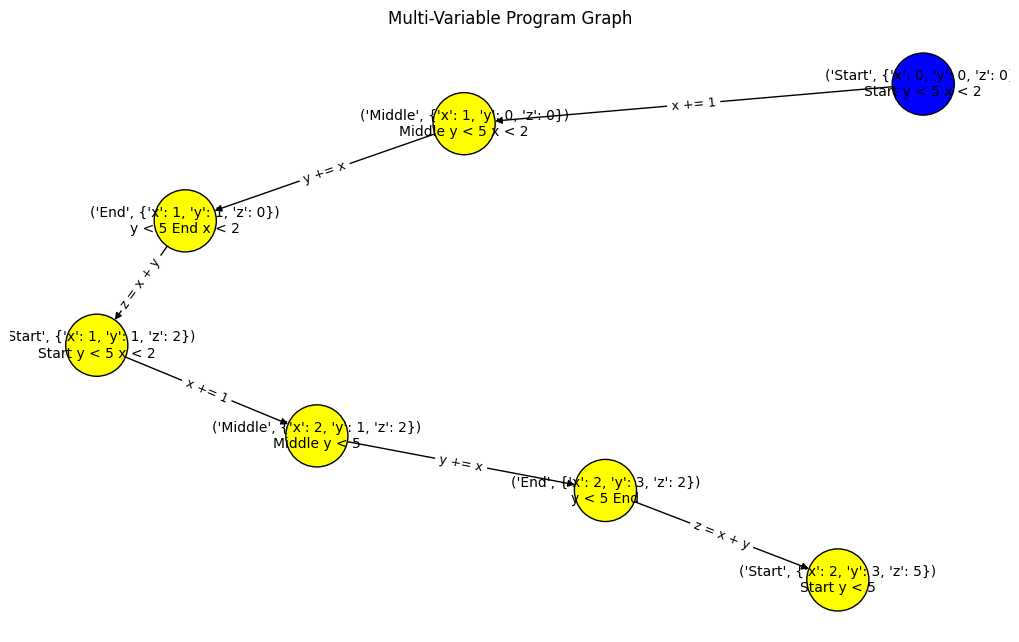

In [6]:
# Program graph with multiple variables
multi_var_pg = ProgramGraph(
    locations={'Start', 'Middle', 'End'},
    initial_locations={'Start'},
    actions={'x += 1', 'y += x', 'z = x + y'},
    transitions={
        ('Start', 'x < 2', 'x += 1', 'Middle'),
        ('Middle', 'y < 5', 'y += x', 'End'),
        ('End', 'True', 'z = x + y', 'Start')
    },
    eval_fn=eval_fn,
    effect_fn=effect_fn,
    g0='x == 0 and y == 0 and z == 0'
)

# Convert to transition system
multi_vars = {'x': {0, 1, 2}, 'y': {0, 1, 2, 3, 4, 5}, 'z': {0, 1, 2, 3, 4, 5, 6, 7}}
multi_labels = {'x < 2', 'y < 5', 'z > 5'}
multi_ts = multi_var_pg.to_transition_system(multi_vars, multi_labels)

# Print the states and transitions
print("States:", multi_ts.S)
print("\nTransitions:")
for transition in multi_ts.Transitions:
    print(transition)

# Test valid_transitions
env = {'x': 1, 'y': 2, 'z': 0}
valid_from_middle = multi_var_pg.valid_transitions('Middle', env, 'y += x')
print("\nValid transitions from Middle with x=1, y=2:", valid_from_middle)

# Visualize
multi_var_pg.plot()
multi_ts.plot(title="Multi-Variable Program Graph")

States: {('Start', {'x': 1}), ('Branch1', {'x': 2}), ('End', {'x': 3})}

Transitions:
(('Branch1', {'x': 2}), 'x += 1', ('End', {'x': 3}))
(('Start', {'x': 1}), 'x += 1', ('Branch1', {'x': 2}))

Valid transitions from Start with x=1:
  - x += 1: [('Start', 'x += 1', 'Branch1')]
  - x *= 2: []

Valid transitions from Start with x=3:
  - x += 1: []
  - x *= 2: [('Start', 'x *= 2', 'Branch2')]


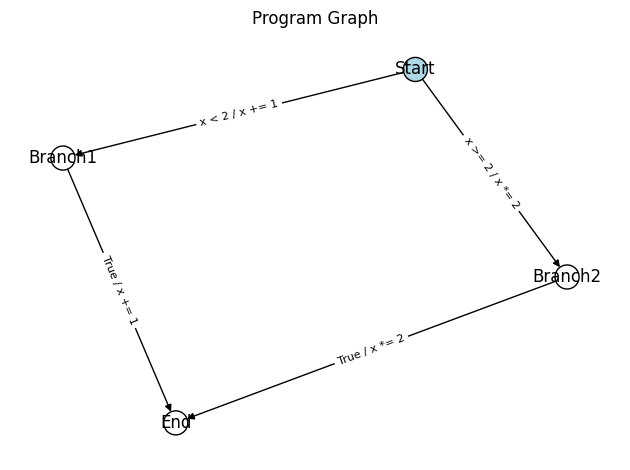

('Start', {'x': 1})
Start x < 2
('Branch1', {'x': 2})
x >= 2 Branch1
('End', {'x': 3})
x >= 2 End


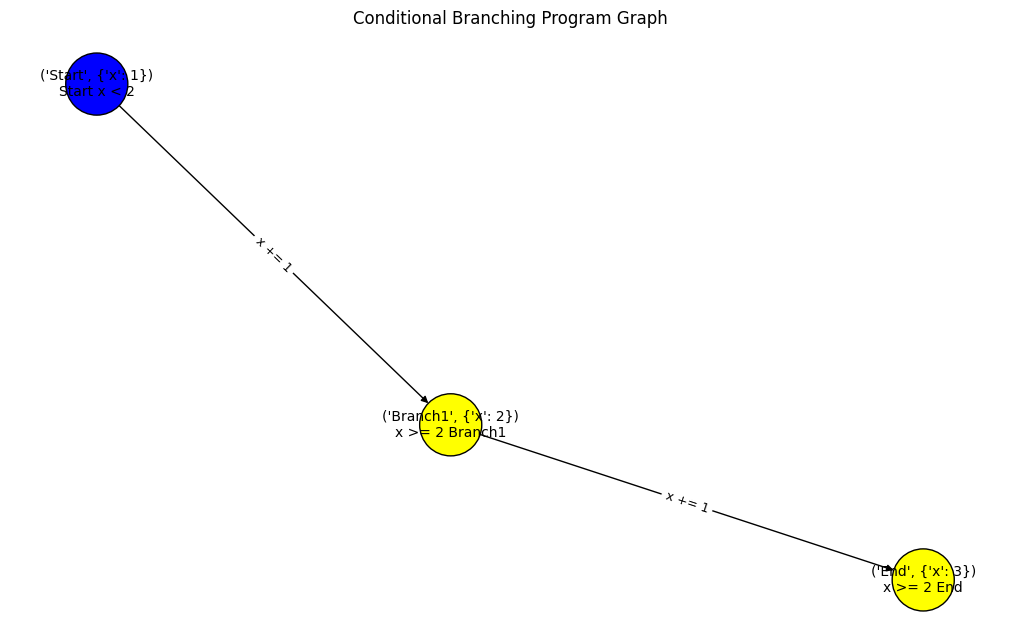

In [7]:
# Program graph with conditional branching
branch_pg = ProgramGraph(
    locations={'Start', 'Branch1', 'Branch2', 'End'},
    initial_locations={'Start'},
    actions={'x += 1', 'x *= 2'},
    transitions={
        ('Start', 'x < 2', 'x += 1', 'Branch1'),
        ('Start', 'x >= 2', 'x *= 2', 'Branch2'),
        ('Branch1', 'True', 'x += 1', 'End'),
        ('Branch2', 'True', 'x *= 2', 'End')
    },
    eval_fn=eval_fn,
    effect_fn=effect_fn,
    g0='x == 1'
)

# Convert to transition system
branch_vars = {'x': {1, 2, 3, 4, 8}}
branch_labels = {'x < 2', 'x >= 2', 'x > 5'}
branch_ts = branch_pg.to_transition_system(branch_vars, branch_labels)

# Print the states and transitions
print("States:", branch_ts.S)
print("\nTransitions:")
for transition in branch_ts.Transitions:
    print(transition)

# Test valid_transitions
env = {'x': 1}
valid_from_start_1 = branch_pg.valid_transitions('Start', env, 'x += 1')
valid_from_start_2 = branch_pg.valid_transitions('Start', env, 'x *= 2')
print("\nValid transitions from Start with x=1:")
print("  - x += 1:", valid_from_start_1)
print("  - x *= 2:", valid_from_start_2)

env = {'x': 3}
valid_from_start_3 = branch_pg.valid_transitions('Start', env, 'x += 1')
valid_from_start_4 = branch_pg.valid_transitions('Start', env, 'x *= 2')
print("\nValid transitions from Start with x=3:")
print("  - x += 1:", valid_from_start_3)
print("  - x *= 2:", valid_from_start_4)

# Visualize
branch_pg.plot()
branch_ts.plot(title="Conditional Branching Program Graph")

States: {('L1', {'flag': True, 'count': 0}), ('L1', {'flag': True, 'count': 1}), ('L0', {'flag': False, 'count': 1}), ('L1', {'flag': True, 'count': 2}), ('L3', {'flag': False, 'count': 3}), ('L2', {'flag': True, 'count': 1}), ('L0', {'flag': False, 'count': 2}), ('L0', {'flag': False, 'count': 0}), ('L2', {'flag': True, 'count': 2}), ('L2', {'flag': True, 'count': 3})}

Transitions:
(('L1', {'flag': True, 'count': 2}), 'count += 1', ('L2', {'flag': True, 'count': 3}))
(('L2', {'flag': True, 'count': 1}), 'flag = False', ('L0', {'flag': False, 'count': 1}))
(('L2', {'flag': True, 'count': 3}), 'flag = False', ('L3', {'flag': False, 'count': 3}))
(('L0', {'flag': False, 'count': 2}), 'flag = True', ('L1', {'flag': True, 'count': 2}))
(('L1', {'flag': True, 'count': 1}), 'count += 1', ('L2', {'flag': True, 'count': 2}))
(('L1', {'flag': True, 'count': 0}), 'count += 1', ('L2', {'flag': True, 'count': 1}))
(('L0', {'flag': False, 'count': 0}), 'flag = True', ('L1', {'flag': True, 'count':

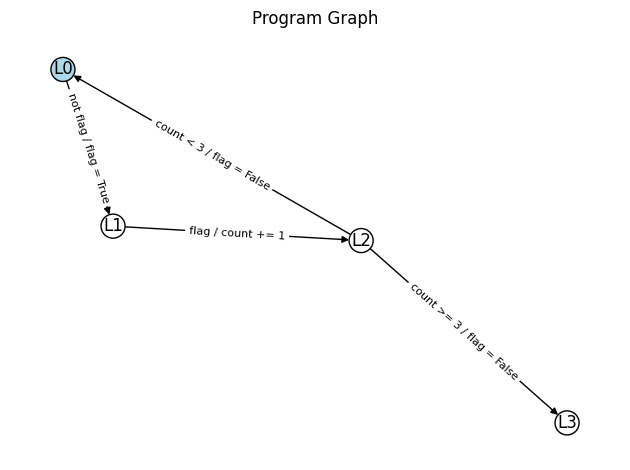

('L1', {'flag': True, 'count': 0})
L1 flag
('L1', {'flag': True, 'count': 1})
L1 flag
('L0', {'flag': False, 'count': 1})
L0
('L1', {'flag': True, 'count': 2})
L1 flag
('L3', {'flag': False, 'count': 3})
count >= 3 L3
('L2', {'flag': True, 'count': 1})
L2 flag
('L0', {'flag': False, 'count': 2})
L0
('L0', {'flag': False, 'count': 0})
L0
('L2', {'flag': True, 'count': 2})
L2 flag
('L2', {'flag': True, 'count': 3})
count >= 3 L2 flag


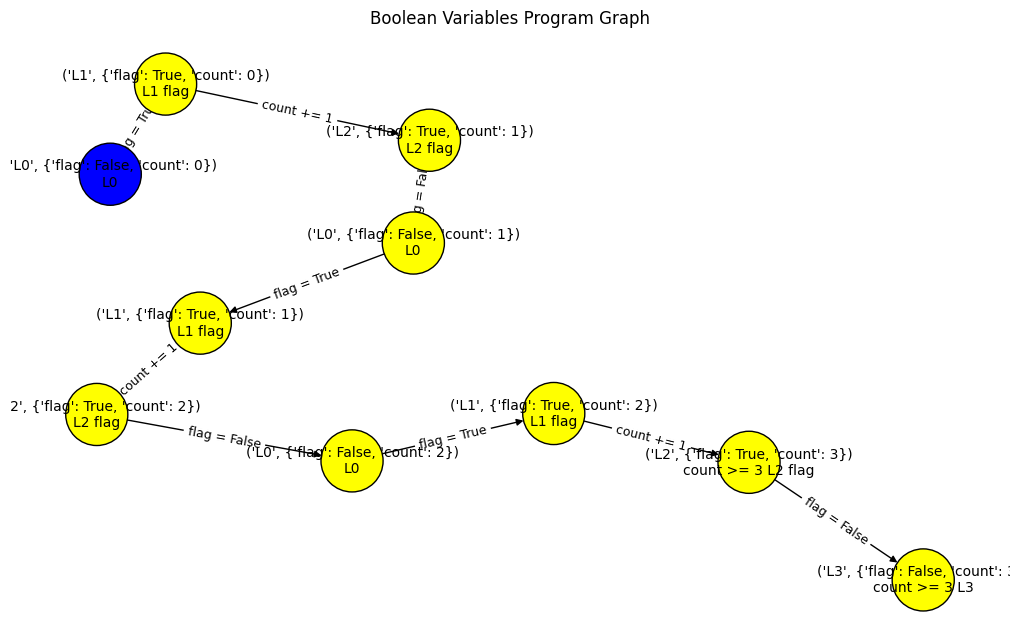

In [8]:
# Program graph with boolean variables
bool_pg = ProgramGraph(
    locations={'L0', 'L1', 'L2', 'L3'},
    initial_locations={'L0'},
    actions={'flag = True', 'flag = False', 'count += 1'},
    transitions={
        ('L0', 'not flag', 'flag = True', 'L1'),
        ('L1', 'flag', 'count += 1', 'L2'),
        ('L2', 'count < 3', 'flag = False', 'L0'),
        ('L2', 'count >= 3', 'flag = False', 'L3')
    },
    eval_fn=eval_fn,
    effect_fn=effect_fn,
    g0='flag == False and count == 0'
)

# Convert to transition system
bool_vars = {'flag': {True, False}, 'count': {0, 1, 2, 3}}
bool_labels = {'flag', 'count >= 3'}
bool_ts = bool_pg.to_transition_system(bool_vars, bool_labels)

# Print the states and transitions
print("States:", bool_ts.S)
print("\nTransitions:")
for transition in bool_ts.Transitions:
    print(transition)

# Test valid_transitions
env = {'flag': False, 'count': 0}
valid_from_L0 = bool_pg.valid_transitions('L0', env, 'flag = True')
print("\nValid transitions from L0 with flag=False:", valid_from_L0)

env = {'flag': True, 'count': 2}
valid_from_L2 = bool_pg.valid_transitions('L2', env, 'flag = False')
print("Valid transitions from L2 with flag=True, count=2:", valid_from_L2)

# Visualize
bool_pg.plot()
bool_ts.plot(title="Boolean Variables Program Graph")

In [9]:
# Function to test both methods on a program graph
def test_program_graph(pg, name, vars_dict, labels_set, test_cases):
    print(f"\n=== Testing {name} ===")
    
    # Convert to transition system
    ts = pg.to_transition_system(vars_dict, labels_set)
    print(f"Transition System has {len(ts.S)} states and {len(ts.Transitions)} transitions")
    
    # Test valid_transitions for specific cases
    for loc, env, action, expected_valid in test_cases:
        valid = pg.valid_transitions(loc, env, action)
        success = "✓" if valid == expected_valid else "✗"
        print(f"{success} valid_transitions({loc}, {env}, {action}) = {valid}")
    
    # Return the transition system for further inspection if needed
    return ts

# Test all program graphs
all_results = {
    "loop": test_program_graph(
        loop_pg, "Loop Program Graph", loop_vars, loop_labels,
        [('L0', {'x': 0}, 'x += 1', [('L0', 'x += 1', 'L1')]),
         ('L3', {'x': 3}, 'x = 0', [('L3', 'x = 0', 'L0')])]
    ),
    "multi_var": test_program_graph(
        multi_var_pg, "Multi-Variable Program Graph", multi_vars, multi_labels,
        [('Middle', {'x': 1, 'y': 2, 'z': 0}, 'y += x', [('Middle', 'y += x', 'End')])]
    ),
    "branch": test_program_graph(
        branch_pg, "Branching Program Graph", branch_vars, branch_labels,
        [('Start', {'x': 1}, 'x += 1', [('Start', 'x += 1', 'Branch1')]),
         ('Start', {'x': 3}, 'x *= 2', [('Start', 'x *= 2', 'Branch2')])]
    ),
    "bool": test_program_graph(
        bool_pg, "Boolean Program Graph", bool_vars, bool_labels,
        [('L0', {'flag': False, 'count': 0}, 'flag = True', [('L0', 'flag = True', 'L1')]),
         ('L2', {'flag': True, 'count': 2}, 'flag = False', [('L2', 'flag = False', 'L0')])]
    )
}


=== Testing Loop Program Graph ===
Transition System has 4 states and 4 transitions
✓ valid_transitions(L0, {'x': 0}, x += 1) = [('L0', 'x += 1', 'L1')]
✓ valid_transitions(L3, {'x': 3}, x = 0) = [('L3', 'x = 0', 'L0')]

=== Testing Multi-Variable Program Graph ===
Transition System has 7 states and 6 transitions
✓ valid_transitions(Middle, {'x': 1, 'y': 2, 'z': 0}, y += x) = [('Middle', 'y += x', 'End')]

=== Testing Branching Program Graph ===
Transition System has 3 states and 2 transitions
✓ valid_transitions(Start, {'x': 1}, x += 1) = [('Start', 'x += 1', 'Branch1')]
✓ valid_transitions(Start, {'x': 3}, x *= 2) = [('Start', 'x *= 2', 'Branch2')]

=== Testing Boolean Program Graph ===
Transition System has 10 states and 9 transitions
✓ valid_transitions(L0, {'flag': False, 'count': 0}, flag = True) = [('L0', 'flag = True', 'L1')]
✓ valid_transitions(L2, {'flag': True, 'count': 2}, flag = False) = [('L2', 'flag = False', 'L0')]


In [10]:
grader.check("q1")

q1 results: All test cases passed!

## 🧠 Question 2: Modeling a Multi-Threaded Counter with a Program Graph

### 🔍 Objective
In this task, you will implement a function that constructs a **Program Graph** representing a simplified **multi-threaded counter protocol**.

Each of the `n_threads` executes a fixed four-step sequence to increment a shared variable `x`. The increment operation is broken into atomic actions using a temporary variable `tmp_i` and a counter variable `count_i` for each thread:

1. `count_i += 1` – mark the start of a new iteration
2. `tmp_i = x` – read
3. `tmp_i += 1` – increment
4. `x = tmp_i` – write

The goal is to repeat this protocol **up to `n_repeats` times per thread**. Once a thread completes all 4 steps, it may loop back to the beginning **only if `count_i < n_repeats`**.


### **🧩 Task 1: Program Graph Definition**

You are required to implement the function:

```python
def counter_program_graph(n_threads: int, n_repeats: int) -> ProgramGraph:
    ...
```

The function should return a valid `ProgramGraph` object with the following properties:

#### 🔹 Locations (`Loc`)
- Each location is a string of length `n_threads`, where each character is in `{1, 2, 3, 4}`.
- The `i`-th character indicates the program counter of thread `i`, representing its progress in the 4-step protocol.
- All combinations of `{1, 2, 3, 4}^n_threads` should be included.

#### 🔹 Initial Location (`Loc0`)
- All threads start at step 1: `'1' * n_threads`

#### 🔹 Actions (`Act`)
Each thread has exactly 4 actions:
1. `count_i += 1` (track iteration count)
2. `tmp_i = x` (read)
3. `tmp_i += 1` (increment)
4. `x = tmp_i` (write)

Total actions: `4 * n_threads`

#### 🔹 Transitions (`Transitions`)
- If a thread is at step 1:
  - It performs `count_i += 1` and may only proceed **if `count_i < n_repeats`**.
- If a thread is at step 2 or 3:
  - It progresses unconditionally using its corresponding action.
- If a thread is at step 4:
  - It always performs `x = tmp_i` and then loops back to step 1.

Each transition updates the corresponding thread's program counter by one (or loops to 1 after step 4).

#### 🔹 Initial Condition (`g0`)
All variables are initialized to 0:
```
x == 0 and tmp_1 == 0 and count_1 == 0 and tmp_2 == 0 and count_2 == 0 ... and tmp_n == 0 and count_n == 0
```

---



### 🔧 Example

For `n_threads = 2` and `n_repeats = 3`, the constructed program graph will include:

#### Locations
All combinations of two digits from `{1, 2, 3, 4}`:
```
{'11', '12', '13', '14', '21', '22', '23', '24', '31', '32', '33', '34', '41', '42', '43', '44'}
```

Each digit represents the program counter (PC) of a thread.
For example, `'24'` means:
- Thread 1 is at PC = 2
- Thread 2 is at PC = 4

#### Actions
Each thread has 4 actions. For 2 threads:
```
[
  'count_1 += 1', 'tmp_1 = x', 'tmp_1 += 1', 'x = tmp_1',
  'count_2 += 1', 'tmp_2 = x', 'tmp_2 += 1', 'x = tmp_2'
]
```

#### Initial Location
```python
'11'
```
Both threads start at PC = 1.

#### Transitions
Each thread moves forward in its 4-step sequence or loops back to 1:

- `'11'` → `'21'` via action `'count_1 += 1'` **if `count_1 < 3`**
- `'21'` → `'31'` via action `'tmp_1 = x'`
- `'31'` → `'41'` via action `'tmp_1 += 1'`
- `'41'` → `'11'` via action `'x = tmp_1'`

These transitions apply similarly for thread 2. All transitions are independent and interleaved.

#### Initial Condition
All variables initialized to 0:
```python
x == 0 and tmp_1 == 0 and count_1 == 0 and tmp_2 == 0 and count_2 == 0
```


In [11]:
# Add your imports here
import itertools
from typing import Set, Dict, Tuple, Union, Callable

def eval_fn(cond, env):
    """Evaluates a condition string in a given environment dictionary."""
    try:
        return eval(cond, {}, env)
    except:
        return False

def effect_fn(action, env):
    """Applies an action (which modifies variables) and returns a new environment."""
    new_env = env.copy()
    try:
        exec(action, {}, new_env)
    except:
        pass
    return new_env

def counter_program_graph(n_threads: int, n_repeats: int) -> ProgramGraph:
    """
    Constructs a Program Graph for a multi-threaded counter protocol.

    :param n_threads: The number of concurrent threads.
    :param n_repeats: The maximum number of times each thread should repeat the protocol.
    :return: A ProgramGraph instance representing the counter protocol.
    """
    locations = set()
    # Generate locations: strings of length n_threads with digits '1' to '4'
    for loc_tuple in itertools.product(['1', '2', '3', '4'], repeat=n_threads):
        locations.add("".join(loc_tuple))

    initial_location = '1' * n_threads
    initial_locations = {initial_location}

    actions = set()
    variables = {'x'} # Shared variable
    for i in range(1, n_threads + 1):
        # Remove spaces from action strings
        actions.add(f"count_{i}+=1")
        actions.add(f"tmp_{i}=x")
        actions.add(f"tmp_{i}+=1")
        actions.add(f"x=tmp_{i}")
        variables.add(f"tmp_{i}")
        variables.add(f"count_{i}")


    transitions = set()
    for loc in locations:
        for i in range(n_threads): # Iterate through each thread (0 to n_threads-1)
            thread_id = i + 1
            current_step = int(loc[i])
            next_loc_list = list(loc)

            if current_step == 1:
                # Remove spaces from action string
                action = f"count_{thread_id}+=1"
                condition = f"count_{thread_id} < {n_repeats}" # Guard for repeating
                next_step = '2'
            elif current_step == 2:
                # Remove spaces from action string
                action = f"tmp_{thread_id}=x"
                condition = "True"
                next_step = '3'
            elif current_step == 3:
                # Remove spaces from action string
                action = f"tmp_{thread_id}+=1"
                condition = "True"
                next_step = '4'
            elif current_step == 4:
                # Remove spaces from action string
                action = f"x=tmp_{thread_id}"
                condition = "True"
                next_step = '1' # Loop back
            else:
                continue # Should not happen

            next_loc_list[i] = next_step
            next_loc = "".join(next_loc_list)

            # Ensure next_loc is valid before adding transition
            if next_loc in locations:
                 transitions.add((loc, condition, action, next_loc))


    # Initial condition g0: all variables start at 0
    g0_parts = ["x == 0"]
    for i in range(1, n_threads + 1):
        g0_parts.append(f"tmp_{i} == 0")
        g0_parts.append(f"count_{i} == 0")
    g0 = " and ".join(g0_parts)

    # Create the ProgramGraph instance
    pg = ProgramGraph(
        locations=locations,
        initial_locations=initial_locations,
        actions=actions,
        transitions=transitions,
        eval_fn=eval_fn,
        effect_fn=effect_fn,
        g0=g0
    )

    return pg

## 🧠 Task 2: Determining Final Values of `x`

### 🔍 Objective

Your task is to analyze the transition system generated from the program graph (created in Task 1) and determine **all possible values** the variable `x` may have when the program **terminates**.

A program execution is considered **terminated** when **all threads have returned to the first step** of their 4-step protocol and **no further transitions are possible** (i.e., the guard `count_i < n_repeats` no longer holds for any thread `i`).

---

### 🎯 Goal

Implement the following function:

```python
def final_x_values(ts: TransitionSystem) -> List[int]:
    """
    Given a transition system created from the counter program graph,
    return a sorted list of all possible final values of x at program termination.
    """
```

The function should return a **sorted list** (from lowest to highest) of all values `x` can take in **terminal states**.

---

### 📌 Terminal State Criteria

A state `(location, environment)` is terminal if:

- The location is `'1' * n_threads` (i.e., all threads are at step 1), **and**
- For every thread `i`, the condition `count_i < n_repeats` evaluates to **False** in the given environment.

You should extract the value of `x` from each such terminal environment.

---

### 🧪 Example

If `n_threads = 2` and `n_repeats = 2`, the program may terminate in multiple ways, resulting in different possible values of `x`, e.g.:

```python
[1, 2, 3, 4]
```

This means the program could terminate with `x in [1, 2, 3, 4]` when all threads complete exactly `2` iterations.
(In other configurations, there may be non-determinism allowing early termination with smaller values.)


In [12]:
from typing import List
# Assuming TransitionSystem and HashableDict are defined above

def final_x_values(ts: TransitionSystem) -> List[int]:
    """
    Given a transition system created from the counter program graph,
    return a sorted list of all possible final values of x at program termination.

    A state (location, environment) is terminal if:
    - The location is '1' * n_threads.
    - The state has no outgoing transitions (Post(state) is empty).

    :param ts: The TransitionSystem generated from the counter program graph.
    :return: A sorted list of unique final values for 'x'.
    """
    final_values = set()
    n_threads = 0

    # Find n_threads from a sample state's location string length
    # Iterate through states until a valid one is found to determine n_threads
    for state in ts.S:
        if isinstance(state, tuple) and len(state) == 2 and isinstance(state[0], str) and state[0]:
            n_threads = len(state[0])
            break
    else: # If loop completes without break (no suitable state found)
         # Try inferring from initial states if S was empty or non-standard
         for state in ts.I:
             if isinstance(state, tuple) and len(state) == 2 and isinstance(state[0], str) and state[0]:
                 n_threads = len(state[0])
                 break
         else:
             # If still no n_threads, we cannot proceed reliably.
             # Check if the TS is essentially empty.
             if not ts.S and not ts.I:
                 return [] # Empty TS has no final values
             else:
                 # This case indicates an issue with TS generation or unexpected state format
                 print("Warning: Could not determine n_threads from TS states. Returning empty list.")
                 return []

    terminal_loc = '1' * n_threads

    for state in ts.S:
        # Check if state matches the expected format (location, environment)
        if isinstance(state, tuple) and len(state) == 2:
            loc, env = state
            # Check if location is the terminal location
            if loc == terminal_loc:
                # Check if the state has no outgoing transitions
                # This implicitly checks if count_i < n_repeats is false for all i
                if not ts.post(state):
                    # Ensure env is a dictionary or HashableDict and contains 'x'
                    if isinstance(env, (dict, HashableDict)) and 'x' in env:
                        # Ensure x is an integer before adding
                        if isinstance(env['x'], int):
                           final_values.add(env['x'])
                        else:
                           print(f"Warning: Terminal state {state} has non-integer 'x' value: {env['x']}.")
                    else:
                         print(f"Warning: Terminal state {state} has unexpected environment format or missing 'x'.")

    return sorted(list(final_values))

In [13]:
# Add necessary imports at the top of the cell.
import itertools
from typing import Set, Dict, Union, List
# Assuming counter_program_graph and final_x_values are defined above
# Assuming TransitionSystem is defined above

def list_x_values(n_threads, n_repeats):
    """
    Generates the counter program graph, converts it to a transition system,
    and finds all possible final values of 'x'.

    :param n_threads: Number of threads.
    :param n_repeats: Number of repeats per thread.
    :return: Sorted list of possible final 'x' values.
    """
    pg = counter_program_graph(n_threads=n_threads, n_repeats=n_repeats)

    # Define variable ranges for the transition system generation
    max_x = n_threads * n_repeats
    max_count = n_repeats # count_i goes from 0 to n_repeats inclusive after increments

    vars_dict: Dict[str, Set[Union[str, bool, int, float]]] = {
        'x': set(range(max_x + 1))
    }
    for i in range(1, n_threads + 1):
        # tmp_i can hold values up to max_x
        vars_dict[f'tmp_{i}'] = set(range(max_x + 1))
        # count_i can hold values from 0 up to n_repeats
        vars_dict[f'count_{i}'] = set(range(max_count + 1))

    # Define labels (optional, can be empty if no specific properties needed beyond location)
    labels_set: Set[str] = set()
    # Example: Add labels to check if x reaches certain values if needed
    # labels_set.add(f"x == {max_x}")

    # Convert the program graph to a transition system
    # This uses the reachability-based implementation in ProgramGraph.to_transition_system
    ts = pg.to_transition_system(vars=vars_dict, labels=labels_set)

    # Find the final values of x using the implemented function
    final_values = final_x_values(ts)

    return final_values

In [14]:
grader.check("q2")

q2 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [15]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)